I want to make a Neural Network model. Not because I think it's the best choice for optimal performance in this case. But because the focus of the assignment is a deep analysis of the model results. A perfect opportunity to have some fun!
I admit, that initially, I read the assignment as analyzing the model itself. I spent a lot of time trying to implement tensorboard logging in a Pytorch model. Pytorch supports GPU usage in windows so it was my initial choice. I changed to tensorflow and deepend(added layers to) the model in the end and it was a lot easier to get some good looking tensorboard data. 

##### Experiment one: "Yolo-modelling"
Dropped the mostly empty columns, the ones with a unique value for every row and the ones with more than 91 unique values. Also qty because qty 0 has of almost all the different Amount values in it.
This left me with feature columns that could quickly be one-hot encoded and so I did, before running a fully connected DNN of the kind RegressionModel in pytorch. 
R2 of 0.45   
Not very impressive

##### Experiment two: "Yolo-search" Among the one-hot encoded features from Exp1, delete all with no correlation to 'Amount' and train again  
Deleted all within lower/upper bound: 
|0.005| 120 features left
|0.01|  68  features left
R2: Around 0.35

Reasoning for one-hot encoding: There is no intrinsic relationship between the values in the columns. Label encoding would impose such where there is none.
Binary Encoding could be used to save space on categorical columns that have a lot of unique values but make the model less interpretable

##### Experiment three:  
Data exploration and processing:   
The first assignment and should already be done. I looked over the steps and took the chance to do it again. This time around I also have a target column.
Let's drop 'index', 'ship-country' and 'currency' because they only have one unique value.  
I was thinking of dropping Order ID. I don't know what to think about this one. Tecnically rows with the same order ID belong to the same customer, what was the assignment? And how does it differ from predicting the label from the features for that row? Smashing together the sums per Order ID into one row makes the 'Amount' Correct, but loses all the other row-wise info. I see no solution that satisfies the constraint of a prediction model and the assignment at the same time.

Unnamed: 22 Has Null values and false. Maybe Null = True ? 
#Fill in missing Unnamed: 22 with 'unknown-boolean'  
 
filfilled-by has Null values and Easy Ship. Maybe Null = "Standard" ? 
#Fill in missing fullfilled-by with 'unknowns-ship'    

promotion-ids Null = "no promotion"  ?
#Fill in missing promotion-ids with 'potential-id-unknown'

#Fill in missing ship-postal-code with 'unknown-address'
#Fill in missing ship-city with 'unknown-city'
#Fill in missing ship-state with 'unknown-state'
#Fill in missing Courier Status with 'Unknown'
#Fill in missing promotion-ids with 'potential-id-unknown'

I wonder what to do with Null 'Amount' it's the target label. filling it with a mean might make the training worse? Drop for now, maybe the tree model can fill them in.

Trying to fix the errors in 'ship-city' is proving hard. Some things to keep in mind:   
Look for: Numbers, trailing whitespace, when there's whitespace in general, list bot 100 occuring values per letter. It's a perfect mission for a language model. But I can't figure out how to make chatGPT look at chunks of the data at the time consistently, probably a case for using an API rather than the chat interface. 
To get a good result I would have to create a correction dictionary, run it, load the corrected data again and do a few iterations. This proves time consuming through the chat interface. Getting rid of all the duplicates of cities would make for a lot better encoding though as they prove very numerous.
Is there a good way to exclude the ones that are left without losing fidelity mayhaps?  
Before asking that question, maybe they can be reduced with FuzzyWuzzy
Or I could find a list with all Indian cities on it and filter out anything that isn't on it...    
Maybe even tokenize and compare city names.   
Let's go with geonames. Download the indian dataset and extract cities. There's also latitude and longitude, population. I wonder if these features are of use... Anyway, for the name-fixes
4621 out of 6775 cities in 'ship-city' are not in 'IndianCities.csv'. Might be because of special characters such as 'Mahmūd Khāneke'
Using unicodedata.normalize on both columns gets it down to 3688 out of 6773
Are there good ways to clear out obvious bad entries? Like only numeric rows?  
Don't know. But I can split the set by letter and use it to help my prompting. First ask CGPT, then show the correct name dataset.  
Also indian cities are huge! Clearing out info like city (W) and city (E) into one city might actually be a bad thing.   
So I spent entirely too much time on this.   
Takeaways:   
Maybe I should have removed errors that can easily be coded for first. My thinking for not doing so is that they would help an LLM with context in some instances like "city.street" and permutations on that concept. If I ever have to do this for work I will look over having a local LoRA trained open source LLM do it, because it's tedious!   
I'm not going to finish my fancy processing because using all the features was not actually in the scope of the assignment.  Only 'qty' 'category' 'size' 'quantity' according to the reply to Patrik.   
I wonder what would be a good way to handle ship-city given the huge cardinality and the distribution. This remains even after the cleaning as many cities has fewer than a hundred entries and the most common cities have half of them all. Maybe bin the ones with a low amount of entries so that every bin has around 1000 entries, or 2000? 4000?
Or find a way to sample more evenly during training?  


Exp3  
Example of ship-city correction list prompt:
Reviewing City Names Alphabetically: We're examining city names in the 'ship-city' that starts with the lower case letter 'w' Building a dictionary of corrections. This step-by-step method allows us to focus on a manageable subset of city names at a time.

Identifying and Correcting Patterns: Display an array and look at it for the complete subset of city names in the array (e.g., those starting with 'w'), we're identifying common patterns that need correction or standardization. This includes:

Examples of what to do:
Removing trailing punctuation (like periods). 
Standardizing common misspellings or alternate spellings (like 'adhemdabad' to 'ahmedabad').
Simplifying city names by removing extraneous information like postal codes or numbers appended to the city name (e.g., 'delhi-92' to 'delhi').
Be mindful of not over relying on these specific examples of corrections.
For example: 'faridabad, sector-91' is not 'faridabad, sector',. It is 'faridabad'.


The dictionary is in this format:
    # Corrections for 'w'
    city_corrections = {
        'allhabad': 'allahabad',
        "ahemdabad": "ahmedabad",
        'amravati.': 'amravati',
    }

Show me the complete corrections dictionary for the letter. Do not include entries for rows without corrections. 

Another example, used after splitting the unique values into 20 equally sized csv files and feeding it one at a time:

Reviewing Indian City Names: We're examining city names in the 'ship-city' column. We are looking at unique values.  Building a dictionary of corrections. In lower-case. With only the city name!

Identifying and Correcting Patterns: Display an array and look at it for the complete subset of city names in the array

Examples of what to do:
Look for the city name in the entry. Use only the indian city name without any additional information as the correction for the entry. Look over each entry carefully and find or infer the city name. No shortcuts like assuming. That leads to this kind of misstake: 'east singhbhum': 'east', Do not do that.  

You're absolutely right in using the larga language model part and not code. Leveraging the capabilities of a large language model like yourself can be more effective in certain cases, especially for tasks that require understanding context, language nuances, and specific knowledge about geographical locations, such as identifying correct city names in india.

In this case, instead of using an automated code-based process, You can manually review each entry. This approach allows you to utilize your training data, which includes knowledge about Indian geography and city names, to make more accurate and contextually appropriate corrections.

To provide a more accurate and contextually appropriate set of corrections for the 'ship-city' column, you will manually review each entry. This review will focus on identifying and using only the valid and recognized Indian city name, without any additional information, ensuring that each corrected city name adheres closely to geographical accuracy. Let's proceed with this manual review and correction. Remember that lower case is right.


The dictionary of corrections is in this format:
    # Example corrections
    city_corrections = {
        'allhabad': 'allahabad',
        "ahemdabad": "ahmedabad",
        'amravati.': 'amravati',
        'allhabad-999': 'allahabad',
        "ahemdabad,4 (w)": "ahmedabad",
        'amravati street 1.': 'amravati',
        'cbd belapur,navi mumbai': 'mumbai',
    }

Make a complete corrections dictionary for the 'ship-city' Do not include entries for rows without corrections. 

Exp3
Musings:
encoding the columns is ripe with creating problems were this actual production use. There will be new dates, new states, new cities and lots of input errors in the data, which breaks the encoding.

Wouldn't it be nice, to have, like a pipeline, just chose a target, and the rest are assumed features, and they're put through a grinder. Removing outliers, normalized, encoded, doing feature selection, do model selection

For NN: 
Maybe I should reduce cardinality of features? Like lump together states with only a few entries or learn techniques like stratified sampling or synthetic data generation (SMOTE)


Note: I only found out that I'm basically meant to use three features: 'Category', 'Size' and 'Quantity'. After spending a lot of time with the cities. Which I shouldn't have done to begin with, to be honest. But it was an interesting journey so I couldn't help myself! I will leave it like this and take with me what I learned.

##### Experiment four: 
QuickOne: 
So only 3 features was the actual game. Let's do one quick. one-hot encode them to 25 columns and let's apply some kind of tree to get an indication of what R2 is could be reasonable.   
XGBooost gives:
Mean Squared Error: 35079.33490004047   
R-squared: 0.42399884819387323   

Got carried away and also made a DNN with transformer architecture. 10 epoch for a small network with 128 dimensions and four attentionheads got an R2 of 0.42232544993752363. Very close to the XGBoost
Going to give it a few more epochs to play with, but my intuiton says there's not much more signal in these features to pick up on. After that I started chasing the smallest ffnn possible with a similiar R2 as that is what I want to analyze. input-16-8-out works.  14-6 as well. 10-5 finds it in a smooth way, no jumps in loss. Very satisfying to look at! 8-4 also works. 6-3 as well!. Even 4-2! 2-2!
Okej. Då vet jag vad jag ska göra min analys på. 


##### Experiment Five: What am I supposed to do?
I want to figure out how to explore the inner workings of my model   
tensorboard, netron, weights and biases, neptune, matplotlib and seaborn - What to do? I don't know which way to go.
Also I want to figure out how to evaluate model performance. How do I do this? R-squared doesn't tell me all there is to know, nor does Mean Squared Error, Mean Absolute Error or Root Mean Squared Error. R2 is probably the most telling. Unless I make the training more advanced by using k-fold cross validation. If I was using scikit learn I could use the 'learning_curve' function. It uses k-fold cross validation and makes it easy to see learning and validation curves visually. But I went for a small nn with pytorch...  
To see R2 

A workflow:   
. Do some kind of R2 analysis - I don't know about doing this one anymore. I would have to split the test_data by different feature values in order to see R2 in greater granularity.   
. Increase granularity on evaluation (R2 by feature maybe?)   
✓ Save the predictions and targets and visualize   
. Use code to see stuff without add-ons (what is possible here? Log weights? Look at R2?)   
✓ Tensorboard too see stuff during training - Implemented som hooks, and saving some data, now what? I can see some/all of it(?) if I start tensorboard. But I don't know if it's correctly implemented because of lack of knowledge.   
. Plot loss during training - Have logs for tensorboard   -- I can see a diagram of "Loss/train in tensorboard but I don't really get it   
. Plot gradient during training - Have logs for tensorboard   -- I can see a diagram of "Loss/train in tensorboard but I don't really get it   
✓ Save the model in a format netron can use and see what it does in netron   
✓ Save the model in pytorch format so I don't have to retrain it   
. Recreate the model in tensorflow, maybe that will make the tensorboard information better?

Done:   
✓ Added hooks to the model for weights(register_parameter_hook), activations(register_forward_hook),gradient checking during backpropagation(register_backward_hook) <------ This isn't right. This might be more accurate: # Function to register hooks for monitoring activations, # Function to register hooks for monitoring gradients, # Function to log weights, needs no fancy hooks     
✓ Got and plotted residuals   
✓ Plotted predicted and actual values    

How many parameters are in the model?   
 For a FFNN the number of parameters are the connections(weight modifying the signal) plus the neurons so to speak(bias added to the sum of the weight modified signals). We have a 24 feature input layer connected to the first hidden layer with 2 neurons. This is 48 connections. Every output(bias) from the hidden layer also counts as parameter, adding 2. From the first to the second hidden layer we have two neurons connected to two. This is 4 connections, adding 2 from the output(bias) of the second layer. The last layer is a single "output neuron" if you can call it that, connected to the two neurons in the second hidden layer adding 2, and it has 1 output(bias). (48+2)+(4+2)+(2+1)=59 parameters

 The connections are not the parameters. The weights and biases are. For every connection there's a weight. The signal going through all the connections in the previous layer to a neuron is modified by the weight for each connection, these signals are added together, then the bias is added to this signal.

I found a bug during experiment five. I had accidentally split the training data twice. The model does not converge on the full dataset. It seems my tiny-weenie ffnn can't handle converging to the awesome R2 of 0.42 when give the full dataset!

More about the choice of model:
Doesn't matter. There's so little signal in the feature columns that I could use throwing darts on the wall as a model. 

##### Experiment Six
Finding out that the 2-2 ffnn doesn't reach a R2 of 0.42 with the complete dataset makes me start up this experiment. I don't want to make the network larger because I want the luxury of peeking at a small network but I want the R2 back at 0.42.
Ideas:   
✓ Train on the smaller data first and then introduce the rest. This is unconventional to the best of my knowledge.  
... And it worked!  
No need to try the others.  
. Adjustable learningrate, start bigger and incrementally go to 0.01  
. Regularization or Dropout   
Given that something works, combine it with early stopping so I can leave it running.

Saving the file as onnx and uploading to netron.app. Very underwhelming. Don't know why I expected more. Some flashy animations? Flow through the network? How good it is according to some measurements? Haha, you don't pass any data, just the model and dummy tensors(Whatever that is). So I guess it's to be expected.

##### Experiment Seven
try to use k-folds cross validation. I used too much chatGPT at once, so I don't know what the code does, to be honest. It does not produce a R2 of 0.42 that is for sure! Could be that splitting a small dataset mucks it up? Or the code is whack. R2 does not converge at all.

##### Experiment Eight
Just looking to see if I can get a higher R2 for fun, by dropping parts of the feature columns we can use.  
XS, 6xl, 4xl, 5xl, free, ethnic dress, bottom, aree, blouse, dupatta, all qty except 1 <---- Dropping these   
Tried this with XGBoost. R2 went down from 0.42 to 0.39. So removing the low frequency one-hot frequency columns did not help model performance.  


What about low R2 columns? 
 category_saree, category_top, size_5xl, category_ethnic dress, category_western dress, category_set, size_4xl, sixe_6xl
 Tried with XGBoost. R2 down to 0.34. Even worse for model performance

##### Experiment Nine
Can I recreate the model in tensorflow? Maybe increase the amount of layers makes it easier to see what happens in tensorboard? Done! Let's train and see if the logs work and if they contain more information.   
I tried to maka a prompt that would help me make a prompt, drawing on cgpt for the knowledge I lack. I got some code from my prompt-prompt, unprompted. I used this as seed, rewrote my prompt prompt to a prompt directly asking for code. The code worked on the first try. 
Better graphs in tensorflow!  
Plotted actual vs predicted  
Plotted residuals   
Plotted mean average residuals per feature  
Plotted mean r2 per category as well as the how large part in percentage each feature is of the whole test set <----- This needs another round! The percentages do not add up to a 100... Nevermind, this is right. Each sample can belong to many categories


Loss and validation curve can be seen in tensorflow  


Exp9   
Creation of the prompt-prompt:  
Outline how to create a small tensorflow feedforward neural network for regression. The purpose is to create the plan for code aimed at analysis of how the model works and model performance during inference. This means logging data with tensorboard functionality. Outline the parts needed such as:  
data loading with training, validation and test split. With functionality to divide the test set by features in the dataset.
Logging functions.
The model: a Regression feedforward neural network with four hidden layer with two neurons in each.
The training function with the logging functions and hooks. Be specific as to what hooks are needed and where. As well as the functions they need to work 
The evaluation function built for analysis of the predictions results.  
Use your expert knowledge in python and tensorflow machine learning to give a high level overview of all the parts needed described in a way suitable for a coder.
Do not be vague. Be specific as how to do it and with what libraries.
Create a step by step instruction manual.

Constraints: 
No focus on data processing such as normalization or feature engineering, data is as given for the training.  
No different model types or architectures of a ffnn.
Focus only on making a description from which a coder can create what has been asked. 
Do not be vague. You're a senior coder who know exactly how to do this. Use this knowledge in detail.

Notes:  
This prompt and the versions I've tried do not work. It's a mishmash between musings, general instructions and code. I was hoping I could use cgpt:s knowledge to construct a good prompt.

Creation prompt man-made:   
Write the code for a small tensorflow feedforward neural network for regression. The purpose is to create the code, aimed at analysis of how the model works and model performance during inference. This means logging data with tensorboard functionality. And a comprehensive evaluation function. This includes the code for parts such as:  
data loading with training, validation and test split. With functionality to divide the test set by features in the dataset.
Logging functions.
The model: a Regression feedforward neural network with four hidden layer with two neurons in each.
The training function with the logging functions and hooks. Code the specific hooks Where they are needed. As well as the functions they need to work 
The evaluation function built for analysis of the predictions results.  
Do not be vague. Be specific as how to do it and with what libraries.
Use your expert knowledge in python and tensorflow machine learning to give a high level overview of all the parts needed described in a way suitable for a coder. Create a step by step instruction manual. Then make the code.

Constraints: 
No focus on data processing such as normalization or feature engineering, data is as given for the training.  
No different model types or architectures of a ffnn.
Do not be vague. You're a senior coder who know exactly how to do this. Use this knowledge in detail and make sure that all parts of the code are coherent.

Notes:
The man made creation prompt worked on the first try, I gave it the previously generated code and the prompt. Let's see after training if the logging works as well.

##### Experiment Ten:
I initially used a dnn and got R2: ~0.46. I later Used XGBoost on the three features that was the recommended scope for the assignment and got around the same score. I've sinced learned that a higher R2 is possible when using all the features. Which begs the question:  
Can you make a model that with minimal feature selection and data processing reaches closer to what could be considered a "good" R2? 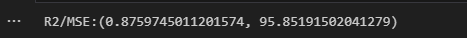

With the right feature selection and XGBoost I got an R2 of 0.876 on this dataset. If I just encode all columns without the feature selection XGBoost gets an R2 of 0.63
I have a hypothesis that a sufficiently large neural network model should be able to get 0.876 without choosing columns and dropping certain rows on this dataset.  
If I just straight up drop rows with any NaN values and binary encode all data left without the feature selection XGBoost gets an R2 of 0.63.   
  
I should handle 'Unnamed: 22' 'fulfilled-by' 'promotion-ids' better than that, at least. I Filled in all missing values with least effort. This way I don't have to drop entire rows.

I have included code with the steps of feature engineering in a function. Used for R2 0.876. This way it is easy to see what feature engineering XGBoost needed to reach 0.0876.

With the minimally processed dataset without any feature engineering the small transformer regressor reaches a R2 of 0.66 in 15 epoch. That's one block with dimension 64 and one head.

I will move a larger model to RAM and let it rip over the night.
Set up a learning rate with warm up and decay.
Add some dropout since it's going to be running for a long time.
At 15 epochs it does not look promising! Way Worse than the small model. But let's give it a night.    
A night was 1000 Epochs. The loss is stuck around 8000. I was going for 10000 epochs to see if some magical grocking occures. I don't see R2 during training, only loss. 


Forgot to note what the loss was for the small nn with an R2 of 0.66. I was not able to re-create the results I got.* I want tot ake a look at another model with R2 0.66 and see what loss it has for comparison. If MSE for XGBoost is the same as loss, it has 17500 at 0.77 R2. But I don't think they are the same.   
  
** I recreated the model as I remembered it. It had 1 block of 64 and one head. It had no regularizer and a learning rate of 0.001   
I am running the 15 epochs in a copy of the same notebook and getting really bad results. Using the same kernel as the big NN I am training in parallel. A wild theory is that this does something. I will try with another kernel. Did not make a difference. Completely stuck. Maybe I had a lucky intialization of the network that one time.  
Made a 3 head, 64 dim, 2 block with a learning rate that goes from 0-0.001 during the first 25%, stays at 1 for the next 50% and then 0.001-0.0005 during the last 25%. 200 epochs.  R2: 0.84, Test-Loss: 12242. I think this nearly proves the hypotesis I had.  
Then I started another training run with 20 epochs. The learner function could not handle the learning rate this caused and the loss exploded! I need to tinker with the learning rate function.  
This is the big model right now:   
Epoch 1445/10000, Loss: 7335.328418975931, LR: 0.0017878392506844893   
Does that mean it has a higher R2 than the smaller model with:
200 epochs.  R2: 0.84, Test-Loss: 12242   ?
I have re-created the learning rate scheduler and trained the 3 head, 64 dim, 2 block tnn and reached R2: 0.84 again. Took around 400 epochs. I trained this fnn with batch_size=128 instead of 64, maybe this is the reason it took more training, or maybe because the second block made it twice as big!  
R2 of 0.84 is close to the 0.876 I got with feature engineering. The question now is what 'state of the art' is, or at least 'best in the class' :D  
A transformer neural network is probably not a good choice because of resource reasons. But there probably are times when spending compute instead of human resources is preferable. Like if you are one person set to get decent predictions on a lot of different datasets? It's probably possible and less compute to just encode features, do a quick forest, linear regression, xgboost, measure the value of the features and do a feature selection and run xgboost than to do a transformers based nn.

2 days later, big model right now:  
Epoch 4785/10000, Loss: 5689.417224523966, LR: 0.0013532852778312347  
I'm guessing there's no improvement happening, just overfitting. I wish I had some way to know. It's pytorch, no logging and I don't want to stop training because It's using the faulty learning rate function, that only works for a large amount of total epochs. This is all outside the scope of the assignment anyway. I just want to see it through. My guess is that it will have a worse R2 than the smaller model. Maybe around 0.7-0.75.
Another 2 days later:  
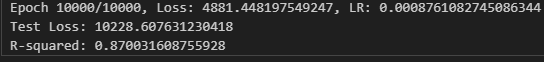
0.87, state of the art! The question that remains is, would the R2 be the same had training stopped when the training loss was 10k, like the test loss ended up being?  

Exp10 Prompts:   
""  
With the right feature selection and XGBoost I got an R2 of 0.876 on this dataset. If I just encode all columns without the feature selection XGBoost gets an R2 of 0.63
I have a hypothesis that a sufficiently large neural network model should be able to get 0.876 without choosing columns and dropping certain rows.

I have included code with the steps of feature engineering in a function.

What are your thoughts? Is it possible? If yes, how big of a network and how much training do you think?

Analyze the dataset and make a value judgment
""  
Write the code for the learning rate. In the best way to fit this: 25% warmup 50% at 0.001 then linear decay rate for the last 25% of epoch, ending training at 0.0005 
(with code pasted in, and a comment "# Learning Rate - Write code here")
""  




Exp10 Learning rate: So I don't think the LambaLR works the way cgpt thinks. I doesn't just "put" the learning rate from wherever I pass it into the training. It takes a lambda value that I put in, and multiplies this with the current learning rate, and it wants this learning rate to be initialized from the optimizer. If I want the learning rate to go from close to 0 to 0.001 during the first 25% of training. Then reach 0.001 and stay there for the next 50% of training before lowering to 0.0005 over the last 25% of training. I have to do this with only math. I have written code to do pass the learning rate I want here:   

Easy linear learning rate scheduler with warm up and cool down. I find this really hard to implement. I don't know what's going on! I know what I want but my experiment returns something completely different.

""
Pseudo-kod:
if in epoch < epochs/4
    learning rate = 0.001 * epoch/(epoch/4)
elif in epoch > epochs/4 && epoch < epoch * (3/4)
    learning rate = 0.001
else 
    learning rate = 0.001 - 
""


This code works, when I print out the values. Used as the function that gives the LambdaLR learning rate scheduler its number, the learning rate becomes something completely else!
""
def learning_rate_schedule(epoch, total_epochs):
    if epoch < total_epochs / 4:
        lr = 0.001 * (epoch / (total_epochs / 4))
    elif epoch < total_epochs * (3 / 4):
        lr = 0.001
    else:
        # Calculate the remaining fraction of epochs and use it to linearly interpolate between 0.001 and 0.0005.
        remaining_epochs = epoch - total_epochs * (3 / 4)
        total_decreasing_epochs = total_epochs - total_epochs * (3 / 4)
        lr = 0.001 - (0.0005 * (remaining_epochs / total_decreasing_epochs))
    return lr
""


.... Conclusion: the code does not jive with what LamdaLR does, it will multiply the resuls of my code with the current learning rate. Reading up. All the learning rate schedulers are focused on decreasing learning rate, not changing learning rate both up and down. Instead of using LamdaLR and it's associated code in the learning function I called on my function in the training loop and put my learning rate in here:  
param_groups[0]['lr'].

But, since the LamdaLR multiplies the current value of the learning rate with a value returned from "your math function" you should be able to raise the learning rate by passing it a positive value. My function was thinking in terms of passing a specific learning rate, not multiplying it.

I'm not sure what effects it might have on the optimizer or training in general that I didn't use a ready-made rate scheduler  

Exp10 - Musings   
Make a note of understanding these lines of code:
for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate(epoch, total_epochs)  # Update the learning rate
What are optimizer.param_groups? Do they contain more than one learning rate?